# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Liu et al. (2016) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model setup
L = 0.01  # length of the plate
N = 10  # mesh density

mesh = UnitSquareMesh(N,N)

# Scale the mesh to the desired domain size
coordinates = mesh.coordinates()
for coord in coordinates:
    coord *= L

In [3]:
#Defining the model parameters
µ_o = -5.71#-0.3124 # initial chemical potential
µ_dry = -1.897 # chemical potential when material is dry
µ_swell = 0 # chemical potential when material is swollen and in equilibrium

µ_diff = 0.0 # chemical potential difference (µ - µ_o) (µ = µ_swell when gel is swollen)

In [4]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [5]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_mu = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = µ_o #-0.3124        # mu
    def value_shape(self):
        return (3,)

In [7]:
# defining the top boundary of the plate
def top(x, on_boundary):
    return near(x[1], L) and on_boundary
# defining the bottom boundary of the plate 
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
# defining the left boundary of the plate
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
# defining the right boundary of the plate
def right(x, on_boundary):
    return near(x[0], L) and on_boundary

In [8]:
# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(W.sub(0).sub(1), Constant(0.0), bottom) 
u_bc_right = DirichletBC(W.sub(0).sub(0), Constant(0.0), right)
u_bc_left = DirichletBC(W.sub(0).sub(0), Constant(0.0), left)

# chemical potential on the outer boundaries
mu_bc_top = DirichletBC(W.sub(1), Constant(µ_swell), top)
# mu_bc_left = DirichletBC(V.sub(1), Constant(µ_swell), left)
mu_bc_right = DirichletBC(W.sub(1), Constant(µ_swell), right)

# bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]
bcs = [u_bc_bottom, u_bc_left, mu_bc_top, mu_bc_right]
# bcs = [u_bc_bottom, u_bc_left, u_bc_right, mu_bc_top]

In [9]:
dU = TrialFunction(W)
(du, dµ) = split(dU)

V_ = TestFunction(W)
(v, q) = split(V_)

U = Function(W)
(u, µ) = split(U)

Uold = Function(W)
(uold, µold) = split(Uold)

# Create intial conditions and interpolate
u_init = InitialConditions()
Uold.interpolate(u_init)

In [10]:
# Model parameters
# Elasticity parameters
# G0, χ = Constant(1.7e7), Constant(0.4)#Constant(0.2)
χ = Constant(0.2)
NΩ = Constant(1e-3) # => N approx 1e20
Ω = Constant(1.7e-28)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
NkBT = Constant(1e25*1.3806488e-23*298)
D = Constant(0.2)#Constant(2e-4)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)

In [11]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [12]:
# Elasticity parameters
E, nu = 70e3, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
G0 = Constant(1e6)#Constant(40e3)#Constant(1e7/(1e25*1.3806488e-23*298))
print(E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model + chem potential)
def psi(u,µ): 
    return variable((G0/2)*(Ic(u) - 3 - 2*ln(J(u))) + (kBT/Ω)*((J(u) - 0.999)*ln(1 - 0.999/J(u)) + χ*(1 - 0.999/J(u)))  - kBT*(µ/Ω)*(J(u) -1)) # <== This is working

40384.61538461538


In [13]:
# first Kirchooff stress - PK1 
def p_mu(u,µ):
    return variable(-µ/(Ω) + 1/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))

def sigma(u,µ):
    return variable(p_mu(u,µ)*I + inv(J(u))*(G0)*(B(u) - I))

def PK1(u,µ):
    return variable(((G0)*(B(u) - I) + J(u)*(-µ + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))*I)*inv(F(u).T))

In [14]:
dt = Constant(0.)

# Total potential energy
Psi_n = psi(u,µ)*dx# - inner(T, u)*ds
Pi_mech = derivative(Psi_n, u, v) 

Jac_mech = derivative(Pi_mech, u, du) + derivative(Pi_mech, µ, dµ)

D = 8.5e-3*kBT # <= this is the minimum value that produces convergence

def mr(u):
    return variable((D/kBT)*inv(B(u))) # <== This one applies neglecting diff dependency of cR

# Mass balance
Pi_chem = (
            (inner(J(u)*grad(u - uold),inv(F(u).T))*q)*dx 
            + dt*inner(mr(u)*grad(µ),grad(q))*dx)

Pi = Pi_mech + Pi_chem 

Jac_chem = derivative(Pi_chem, u, du) + derivative(Pi_chem, µ, dµ) 

Jac = Jac_mech + Jac_chem

In [15]:
Nincr = 10
t = np.linspace(0, 10, Nincr+1)
Nx = 100
x = np.linspace(0, L, Nx)
µ_res = np.zeros((Nx, Nincr+1))

Jx_array = np.zeros((Nx, Nincr+1))

lambda0_array = np.zeros((Nx, Nincr+1))
lambdaL_array = np.zeros((Nx, Nincr+1))

sigmaxx0_array = np.zeros((Nx, Nincr+1))
sigmaxxL_array = np.zeros((Nx, Nincr+1))

sigma_y_array = np.zeros((Nx, Nincr+1))

PK1xx0_array = np.zeros((Nx, Nincr+1))
PK1xxL_array = np.zeros((Nx, Nincr+1))

S = FunctionSpace(mesh, element_mu)

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    print("t =", t_current) 
    dt.assign(dti)
 
    solve(Pi == 0, U, bcs, J = Jac, solver_parameters={"newton_solver":
                                        {"convergence_criterion": "incremental","maximum_iterations": 200}})
        #     {"relative_tolerance": 1e-6, "linear_solver": "gmres", "convergence_criterion": "incremental", "relaxation_parameter": 0.9}})
    Uold.assign(U)
    µ_res[:, i+1] = [U(L/2, xi)[2] for xi in x]

    (u, µ) = U.split()

    Jx0 = J(u)**(1/2)
    Jx0_P1 = project(Jx0, S)
    Jx_array[:, i+1] = [Jx0_P1(L/2, xi) for xi in x] 
    lambda0_array[:, i+1] = [Jx0_P1(0.0, xi) for xi in x]
    lambdaL_array[:, i+1] = [Jx0_P1(L, xi) for xi in x]

    sigmaxx = sigma(u,µ)[0,0]/NkBT
    sigmaxx_P1 = project(sigmaxx, S)
    sigmaxx0_array[:, i+1] = [sigmaxx_P1(0.0, xi) for xi in x] 
    sigmaxxL_array[:, i+1] = [sigmaxx_P1(L, xi) for xi in x]  

    sigma_y = p_mu(u,µ)
    sigma_y_P1 = project(sigma_y, S)
    sigma_y_array[:, i+1] = [sigma_y_P1(L, xi) for xi in x]   

    PK1xx = PK1(u,µ)[0,0]
    PK1xx_P1 = project(PK1xx, S)
    PK1xx0_array[:, i+1] = [PK1xx_P1(0.0, xi) for xi in x] 
    PK1xxL_array[:, i+1] = [PK1xx_P1(L, xi) for xi in x]  

    plt.figure(figsize=(6,5))
    p = plot(u, mode="displacement")
    plt.xlim((-0.0005, 0.02))
    plt.ylim((-0.0005, 0.02))
    # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
    plot(mesh, linewidth=1.0)
    # cbar = plt.colorbar(p)#, shrink = 0.5)
    # cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coord. [m]", fontsize=16)
    plt.ylabel("$Y$-coord. [m]", fontsize=16)
    # plt.legend(["deformed gel"])
    # plt.title("deformed gel ($t = {:.1f}$ [s])".format(t_current), fontsize = 14)
    # plt.savefig('results/Liu/time/Fig_2DFEM_def_gel_x001_{:.1f}.pdf'.format(t_current))
    plt.close()
    
    plt.figure(figsize=(6,5))
    p = plot(J(u)**(1/2))
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=16)
    plt.tick_params(axis='both', labelsize=18)
    plt.xlabel("$X$-coordinate", fontsize=18)
    plt.ylabel("$Y$-coordinate", fontsize=18)
    plt.title("stretch $\lambda$", fontsize = 18)
    # plt.savefig('results/Liu/Fig_2DFEM_stretch_{:.1f}.pdf'.format(t_current))
    plt.close() 

    plt.figure(figsize=(6,5))
    p = plot(PK1(u,µ)[0,0], title="$PK1_{xx}/Nk_{B}T$ normalized nominal stress")
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coordinate", fontsize=16)
    plt.ylabel("$Y$-coordinate", fontsize=16)
    plt.title("stress $PK1_{xx}$", fontsize = 18)
    # plt.savefig('results/Liu/Fig_2DFEM_stress_{:.1f}.pdf'.format(t_current))
    plt.close()

    plt.figure(figsize=(6,5))
    p = plot(PK1(u,µ)[1,1], title="$PK1_{yy}/Nk_{B}T$ normalized nominal stress")
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coordinate", fontsize=16)
    plt.ylabel("$Y$-coordinate", fontsize=16)
    plt.title("normalized stress $PK1_{yy}/Nk_B T$", fontsize = 18)
    # plt.savefig('results/Liu/Fig_2DFEM_stress_{:.1f}.pdf'.format(t_current))
    plt.close()

    plt.figure(figsize=(6,5))
    p = plot(PK1(u,µ)[1,0], title="$PK1_{xy}/Nk_{B}T$ normalized nominal shear stress")
    cbar = plt.colorbar(p)#, shrink = 0.5)
    cbar.ax.tick_params(labelsize=14)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("$X$-coordinate", fontsize=16)
    plt.ylabel("$Y$-coordinate", fontsize=16)
    plt.title("normalized stress $PK1_{xy}/Nk_B T$", fontsize = 18)
    # plt.savefig('results/Liu/Fig_2DFEM_stress_{:.1f}.pdf'.format(t_current))
    plt.close()       

Increment 1
t = 1.0
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Solving nonlinear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Newton iteration 0: r (abs) = 5.127e-04 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.362e-03 (tol = 1.000e-10) r (rel) = 4.607e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.565e-03 (tol = 1.000e-10) r (rel) = 1.476e+01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.747e-02 (tol = 1.000e-10) r (rel) = 3.407e+01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.251e-02 (tol = 1.000e-10) r (rel) = 6.341e+01 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 5.577e-02 (tol = 1.000e-10) r (rel) = 1.088e+02 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 8.140e-02 (tol = 1.000e-10) r (rel) = 1.588e+02 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 4.605e-02 (tol = 1.000e

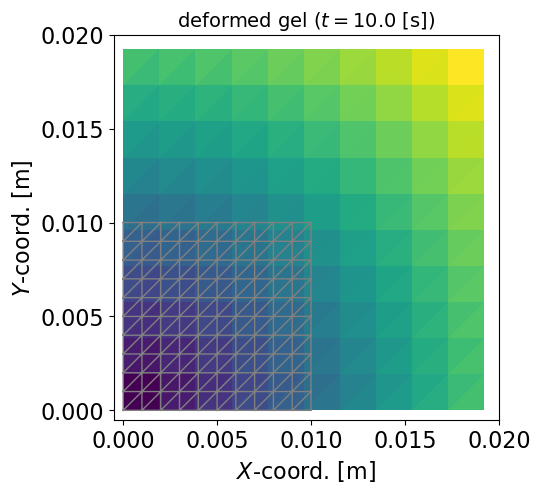

In [16]:
plt.figure(figsize=(6,5))
p = plot(u, mode="displacement")
plt.xlim((-0.0005, 0.02))
plt.ylim((-0.0005, 0.02))
# plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
plot(mesh, linewidth=1.0)
# cbar = plt.colorbar(p)#, shrink = 0.5)
# cbar.ax.tick_params(labelsize=14)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel("$X$-coord. [m]", fontsize=16)
plt.ylabel("$Y$-coord. [m]", fontsize=16)
# plt.legend(["deformed gel"])
plt.title("deformed gel ($t = {:.1f}$ [s])".format(t_current), fontsize = 14)
# plt.savefig('results/Liu/time/Fig_2DFEM_def_gel_x001_bench_{:.1f}.pdf'.format(t_current))
plt.show()

1100


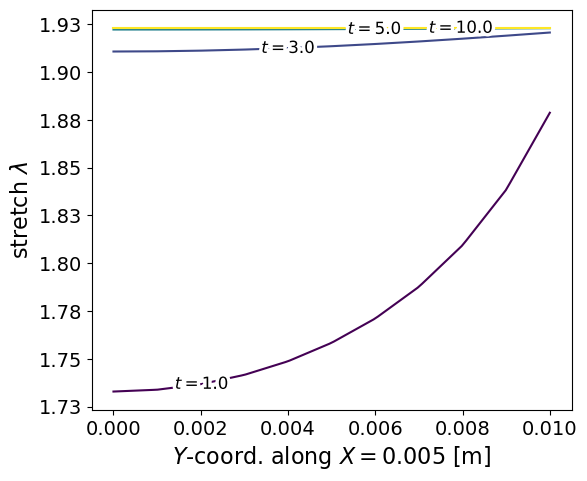

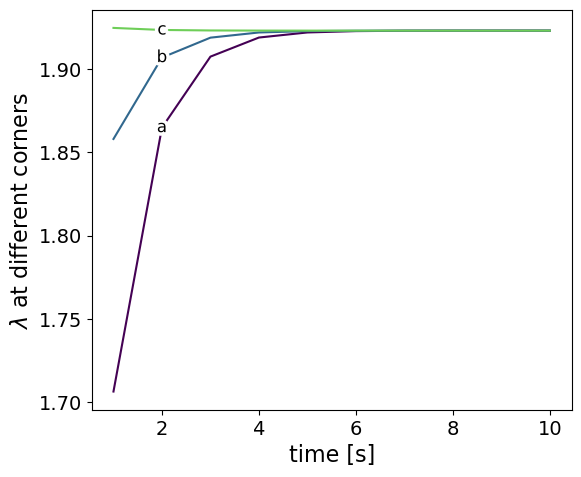

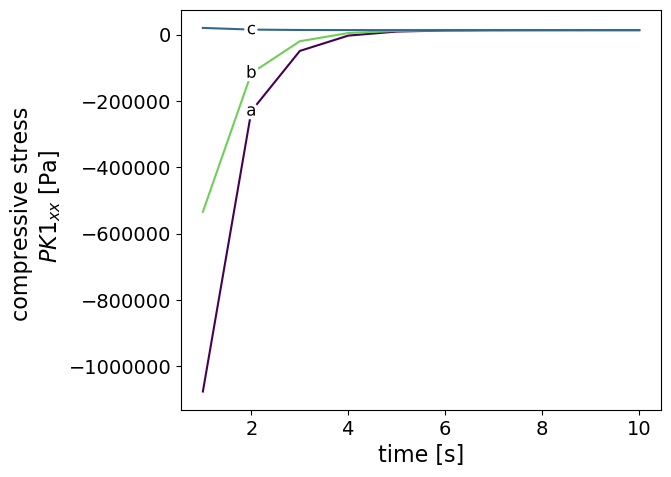

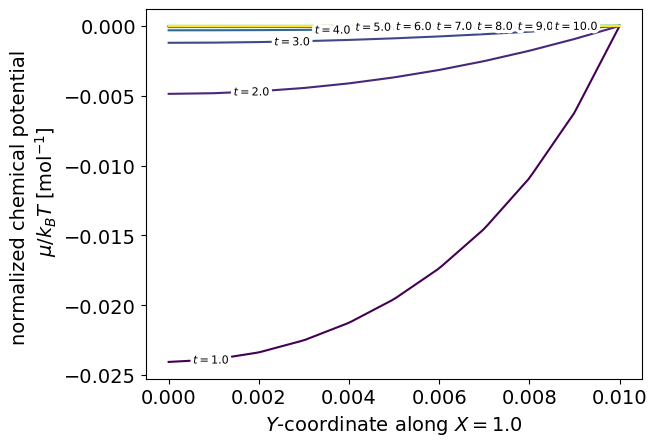

In [17]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[0]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in [0,2,4,9]:
    ax.plot(x, Jx_array[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))


labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=12)
ax.set_xlabel("$Y$-coord. along $X=0.005$ [m]", fontsize=16)
ax.set_ylabel("stretch $\lambda$", fontsize=16)
# ax.legend(["reference 1D sol.", "2D FEM approx."], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda Jx_array, pos: "{:.2f}".format(Jx_array)))

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Liu/Fig_2DFEM_lambda_x001_bech.pdf')

# stretch
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

print(lambda0_array.size)

ax.plot(t[1:], lambda0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], lambda0_array[-1, 1:], color=colormap(normalize(3)), label="b")
ax.plot(t[1:], lambdaL_array[-1, 1:], color=colormap(normalize(7)), label="c")

xvals = [2, 2, 2]
labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=12)
ax.set_xlabel("time [s]", fontsize=16)
ax.set_ylabel("$\lambda$ at different corners", fontsize=16)
# ax.legend(["bottom-left edge", "bottom-right edge", "top-left edge"], fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

# plt.savefig('results/Liu/Fig_2DFEM_stretch_x001_bench.pdf')

# stress
fig, ax = plt.subplots(figsize=(6,5))
# ax = axes[2]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

ax.plot(t[1:], PK1xx0_array[0, 1:], color=colormap(normalize(0)), label="a")
ax.plot(t[1:], PK1xx0_array[-1, 1:], color=colormap(normalize(7)), label="b")
ax.plot(t[1:], PK1xxL_array[-1, 1:], color=colormap(normalize(3)), label="c")

xvals = [2, 2, 2]
labelLines(ax.get_lines(), align=False, xvals=xvals, color="k", fontsize=12)
ax.set_xlabel("time [s]", fontsize=16)
# ax.set_ylabel("normalized stress at different edges \n $PK1_{xx}/Nk_B T$ [MPa/MPa]", fontsize=14)
ax.set_ylabel("compressive stress \n $PK1_{xx}$ [Pa]", fontsize=16)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust the margins
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
# plt.savefig('results/Liu/Fig_2DFEM_PK1_x001_bench.pdf')
# plt.savefig('results/Liu/Fig_2DFEM_mu_stretch_PK1.pdf')
plt.show()

# chemical potential
fig, ax = plt.subplots()
# ax = axes[2]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

for n in nValues:
    ax.plot(x, µ_res[:, n+1], color=colormap(normalize(n)), label="$t = {:.1f}$".format(t[n+1]))#, label=str(t[n]))

labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=8)
ax.set_xlabel("$Y$-coordinate along $X=1.0$", fontsize=14)
ax.set_ylabel("normalized chemical potential \n $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
# ax.legend(["reference 1D sol.", "2D FEM approx."])
ax.tick_params(axis='both', which='major', labelsize=14)